In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import json
import random
import os, sys
from os import path, makedirs
from pathlib import Path
from typing import List, Union, Tuple

import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.getcwd())
sys.path.append(path.join(os.getcwd(), "TSB_UAD"))

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
# ! add ```plt.show()``` to utils/slidingWindow.py/plotFig to display plots
from TSB_UAD.utils.slidingWindows import find_length,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.sand import SAND


In [2]:
# Setup GPU

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from torch.cuda import current_device, is_available
print(is_available(), current_device())

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # list shouldn't be empty in case GPU is available 

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


True 0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h1>Generate Dataset</h1>

In [3]:
base_path = "TSB-UAD-Public"

def read_dataset_as_df(filepath):
    df = pd.read_csv(filepath, header=None).dropna()
    df[0] = df[0].astype(float) # assuming univariate
    df[1] = df[1].astype(int)   # label
    return df

def generate_dataset(filenames: List[str], sample_size: Union[int, float] = None):
    # Read
    filenames = [Path(base_path, fp) for fp in filenames]
    normality = len(filenames)
    datasets = [read_dataset_as_df(fp) for fp in filenames]

    # Sampling
    if sample_size is not None:
        if sample_size <= 1:  # sample size was defined as a percentage of the original series' size
            sample_size = [int(dataset.shape[0] * sample_size) for dataset in datasets]
        else:  # sample size was defined as maximun number of points
            sample_size = [min(dataset.shape[0], sample_size) for dataset in datasets]

        for i, (dataset_sample_size, dataset) in enumerate(zip(sample_size, datasets)):
            datasets[i] = dataset[:dataset_sample_size]

    # Concatenate
    shift_idxs = []
    if len(datasets) > 1:
        cumulative_length = 0
        for i, dataset in enumerate(datasets[:-1]):
            cumulative_length += len(dataset)
            shift_idxs.append(cumulative_length)

    # Concatenate the list of DataFrames along rows (axis=0)
    merged_dataset = pd.concat(datasets, ignore_index=True)
    return merged_dataset, normality, shift_idxs



In [4]:

def _plot_generated_dataset(df: pd.DataFrame,
                           x_values,
                           shift_idxs=None):
    
    y_values = df[0].values         # First column ('0') values as y-values
    color_values = df[1].values     # Second column ('1') values for coloring (0 or 1)

    # Plotting the time series with conditional coloring
    plt.figure(figsize=(12,4))  # Set the figure size (width, height)

    # Plot the entire time series as a line plot
    plt.plot(x_values, y_values, color='black', linewidth=2)

    # Initialize segment start index and color
    segment_start = 0
    current_color = color_values[0]

    # Iterate over data points to plot line segments with different colors
    for i in range(1, len(df)):
        if color_values[i] != current_color:
            # Plot the previous segment with the current color
            plt.plot(x_values[segment_start:i], y_values[segment_start:i], color='red' if current_color == 1 else 'black', linewidth=2)
            # Update segment start index and current color
            segment_start = i
            current_color = color_values[i]

    # Plot the last segment
    plt.plot(x_values[segment_start:], y_values[segment_start:], color='red' if current_color == 1 else 'black', linewidth=2)
    
    for shift_idx in shift_idxs:
        plt.axvline(shift_idx, color='blue', linestyle='--', linewidth=1.5)

    # Display the plot
    plt.show()

def plot_generated_dataset(df: pd.DataFrame, 
                           plot_around_distro_shifts=False, 
                           plot_range=1000,
                           shift_idxs: List[int]=None):
    
    # Extract values from DataFrame
    if plot_around_distro_shifts and shift_idxs is not None and len(shift_idxs) > 0:
        for shift_idx in shift_idxs:  # different plot for each distro shift
            x_values = np.arange(shift_idx - plot_range, shift_idx + plot_range + 1)
            df_partial = df.loc[x_values]
            _plot_generated_dataset(df_partial, x_values, [shift_idx])
    
    else:
        x_values = np.arange(len(df))  # Use numerical index as x-values
        _plot_generated_dataset(df, x_values, shift_idxs)


<h4>TSB - public time series samples (one file from each dataset)</h4>

In [5]:
DODGERS = 'Dodgers/101-freeway-traffic.test.out'
ECG = 'ECG/MBA_ECG803_data.out'
IOPS = 'IOPS/KPI-0efb375b-b902-3661-ab23-9a0bb799f4e3.test.out'
KDD21 = 'KDD21/005_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature1_4000_5391_5392.out'
MGAB = 'MGAB/1.test.out'
NAB = 'NAB/NAB_data_Traffic_1.out'
SENSORSCOPE = 'SensorScope/stb-2.test.out'
YAHOO = 'YAHOO/Yahoo_A1real_1_data.out'
DAPHNET = 'Daphnet/S01R02E0.test.csv@1.out'
GHL = 'GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.test.csv@4.out'
GENESIS = 'Genesis/genesis-anomalies.test.csv@1.out'
MITDB = 'MITDB/100.test.csv@1.out'
OPPORTUNITY = 'OPPORTUNITY/S1-ADL1.test.csv@16.out'
OCCUPANCY = 'Occupancy/room-occupancy.train.csv@3.out'
SMD = 'SMD/machine-1-1.test.csv@1.out'
SVDB = 'SVDB/801.test.csv@1.out'

In [6]:
# sample_size should be None to get the whole time series

def load_dataset(filenames: List[str], sample_size=100000, plot_series=True) -> Tuple[pd.DataFrame, int, List[int]]:

    df, normality, shift_idxs = generate_dataset(filenames, sample_size=sample_size)

    print(f"Series len = {df.shape[0]}\nNormality = {normality}\nDistro shift indexes = {shift_idxs}")
    if plot_series:
        plot_generated_dataset(df, plot_around_distro_shifts=True, plot_range=5000, shift_idxs=shift_idxs)
    
    return df, normality, shift_idxs


Series len = 100000
Normality = 1
Distro shift indexes = []


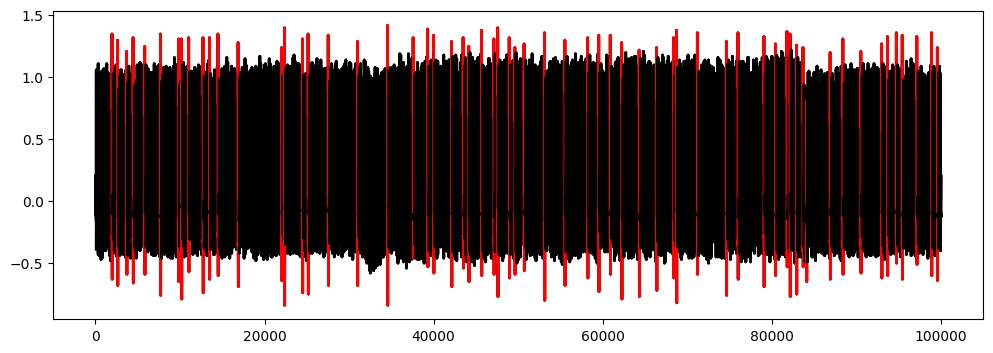

In [7]:
# How to load a dataset. For normality>1, add multiple time series files to the filenames list

filenames = [ECG]
df, normality, shift_idxs = load_dataset(filenames)


<h1>Evaluation Metrics / Save Results</h1>

In [11]:

output_path_base = path.join("OUTPUTS", "results")

def save_dict_to_json_file(dictionary, filename):
    makedirs(path.dirname(filename), exist_ok=True)
    
    with open(filename, 'w', encoding='utf-8') as json_file:
        json.dump(dictionary, json_file, indent=4, ensure_ascii=False)

# save TSB report to a json file
def gather_TSB_results(model_name, online, label, score, slidingWindow, filenames, normality, elapsed_time, save_to_json=True):
    
    filenames_norm = "_".join(filenames)
    filenames_norm = re.sub(r'[^A-Za-z0-9_]', '.', filenames_norm)
    output_json = path.join(output_path_base, f"normality_{normality}", f"{filenames_norm}_{model_name}_{'online' if online else 'offline'}.json")
    
    results = printResult(None, label, score, slidingWindow, None, None)
    results = [float(value) for value in results]
    results = {
        "model": model_name,
        "online": online,
        "normality": normality,
        "datasets": filenames,
        "series_length": len(label),
        "window": int(slidingWindow),
        "AUC": results[0],
        "Precision": results[1],
        "Recall": results[2],
        "F": results[3],
        "Precision@k": results[9],
        "Rprecision": results[7],
        "Rrecall": results[4],
        "Rf": results[8],
        "ExistenceReward": results[5],
        "OverlapReward": results[6],
        "RAUC": results[10],
        "time": elapsed_time
    }
    save_dict_to_json_file(results, output_json)
    return results



def gather_AELSTM_results(
    model_name:str, time_series_len:int, filenames:List[str], normality:int, AELSTMresults,
    label, scores, slidingWindow, elapsed_time):
    
    filenames_norm = "_".join(filenames)
    filenames_norm = re.sub(r'[^A-Za-z0-9_]', '.', filenames_norm)
    output_json = path.join(output_path_base, f"normality_{normality}", f"{filenames_norm}_{model_name}_online.json")
    
    TSBresults = printResult(None, label, score, slidingWindow, None, None)
    TSBresults = [float(value) for value in TSBresults]

    results = {
        "model": model_name,
        "online": True,
        "normality": normality,
        "datasets": filenames,
        "series_length": time_series_len,
        "window": int(slidingWindow),
        "AUC": float(AELSTMresults['AUC']),
        "Precision": float(AELSTMresults['report']['anamoly']['precision']),
        "Recall": float(AELSTMresults['report']['anamoly']['recall']),
        "F": float(AELSTMresults['report']['anamoly']['f1-score']),
        "Precision@k": TSBresults[9],
        "Rprecision": TSBresults[7],
        "Rrecall": TSBresults[4],
        "Rf": TSBresults[8],
        "ExistenceReward": TSBresults[5],
        "OverlapReward": TSBresults[6],
        "RAUC": TSBresults[10],
        "Accuracy": float(AELSTMresults['Accuarcy']),
        "confusion_matrix": AELSTMresults['confusion matrix'].astype(int).tolist(),
        "time": elapsed_time
    }
    save_dict_to_json_file(results, output_json)
    return results


<h1>SAND method</h1>
<h3>[Q5] Streaming baseline AD method</h3>

In [13]:

def SAND_model(df: pd.DataFrame, filenames: List[str], normality: int):
    
    name = "_".join(filenames)
    modelName='SAND'
    start_time = time.time()
    
    # process data
    data = df[0]
    label = df[1]
    slidingWindow = find_length(data)
    
    print("Estimated Subsequence length: ",slidingWindow)
    print("Time series length: ",len(data))
    print("Number of abnormal points: ",list(label).count(1))
    
    # train model 
    clf = SAND(pattern_length = slidingWindow, subsequence_length = 4*(slidingWindow))
    x = data
    clf.fit(x, online=True, alpha=0.5, init_length=5000, batch_size=5000, verbose=True, overlaping_rate=int(4*slidingWindow))
    
    # test
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    elapsed_time = time.time() - start_time
    # ! add ```plt.show()``` to utils/slidingWindow.py/plotFig to display plots
    plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)
    
    # save results
    return gather_TSB_results(modelName, True, label, score, slidingWindow, filenames, normality, elapsed_time)


Estimated Subsequence length:  125
Time series length:  100000
Number of abnormal points:  4650
0-->5000-->10000-->15000-->20000-->25000-->30000-->35000-->40000-->45000-->50000-->55000-->60000-->65000-->70000-->75000-->80000-->85000-->90000-->95000-->[STOP]: score length 100000


{'model': 'SAND',
 'online': True,
 'normality': 1,
 'datasets': ['ECG/MBA_ECG803_data.out'],
 'series_length': 100000,
 'window': 125,
 'AUC': 0.9883117726993363,
 'Precision': 0.8078276165347406,
 'Recall': 0.39505376344086024,
 'F': 0.5306181398035817,
 'Precision@k': 0.39505376344086024,
 'Rprecision': 0.8399553505771424,
 'Rrecall': 0.4321720430107527,
 'Rf': 0.5707057669325404,
 'ExistenceReward': 0.5806451612903226,
 'OverlapReward': 0.3950537634408602,
 'RAUC': 0.9982257034100075,
 'time': 92.862722158432}

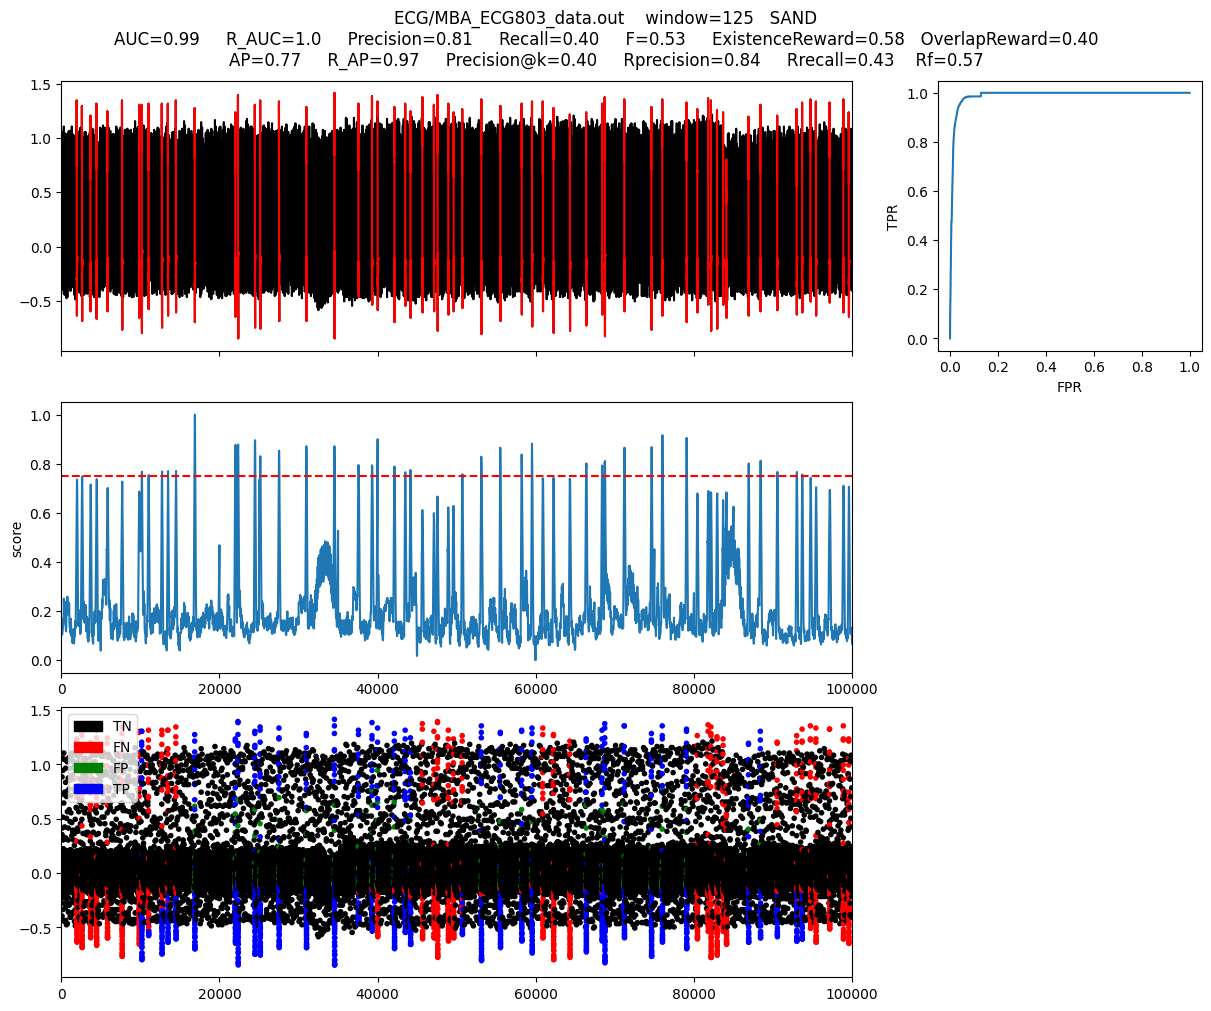

In [14]:
SAND_model(df, filenames, normality)

<h1>EncDec-AD </h1>
<h3>[Q4] Offline/Non-streaming baseline method</h3>
<p>LSTM Encoder/Decoder methodology - DeepADoTS implementation</p>
    

In [15]:
sys.path.append(path.join(os.getcwd(), "EncDec-AD"))
from enc_dec_ad import EncDecAD
from torch.cuda import is_available, current_device
from sklearn.metrics import roc_auc_score, fbeta_score

In [16]:
def separate_sets(X, Y, train_perc=0.1, val_perc=0.0):
    train_idx = int(train_perc * len(X))
    X_train, Y_train = X[:train_idx].reset_index(drop=True), Y[:train_idx].reset_index(drop=True)
    
    if val_perc > 0.0:
        val_idx = int(val_perc * len(X))
        X_val, Y_val = X[train_idx:train_idx + val_idx].reset_index(drop=True), Y[train_idx:train_idx + val_idx].reset_index(drop=True)
    else:
        X_val, Y_val = None, None
    
    test_idx = train_idx + (val_idx if val_perc > 0.0 else 0)
    X_test, Y_test = X[test_idx:].reset_index(drop=True), Y[test_idx:].reset_index(drop=True)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test


In [17]:
device = current_device() if is_available() else None
print(f"Device = {device}")

def EncDecAD_model(df: pd.DataFrame, filenames: List[str], normality: int, online_mode=False):
    name = "_".join(filenames)
    modelName = "EncDec-AD"
    start_time = time.time()
    
    # prepare dataset
    X = df[[0]]
    Y = df[1]
    n_features = X.shape[1]
    slidingWindow = find_length(X[0])
    X_train, Y_train, X_val, Y_val, X_test, Y_test = separate_sets(X, Y, train_perc=0.2, val_perc=0)

    # train
    batch_size = min(int(4 * (slidingWindow // 100) * 100), X_train.shape[0])
    model = EncDecAD(n_features = n_features,
                     hidden_size = 32,
                     sequence_length = slidingWindow,
                     gpu = device)
    model.fit(X_train, num_epochs=40, batch_size=batch_size)

    # test
    score, loss = model.predict(X_test, batch_size=batch_size)
    elapsed_time = time.time() - start_time
    
    if online_mode:
        return score, X_test, Y_test
    else:
        # show evaluation results
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        plotFig(X_test[0], Y_test, score, slidingWindow, fileName=name, modelName=modelName)
        return gather_TSB_results(modelName, online_mode, Y_test, score, slidingWindow, filenames, normality, elapsed_time)
    
    

Device = 0


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [05:48<00:00,  8.70s/it]


{'model': 'EncDec-AD',
 'online': False,
 'normality': 1,
 'datasets': ['ECG/MBA_ECG803_data.out'],
 'series_length': 80000,
 'window': 125,
 'AUC': 0.7739551960712225,
 'Precision': 0.25096030729833546,
 'Recall': 0.10666666666666667,
 'F': 0.14970402902425053,
 'Precision@k': 0.10666666666666667,
 'Rprecision': 0.08378536446718265,
 'Rrecall': 0.26926077097505674,
 'Rf': 0.12780262729458883,
 'ExistenceReward': 1.0,
 'OverlapReward': 0.08657596371882087,
 'RAUC': 0.74026842560762,
 'time': 370.1292839050293}

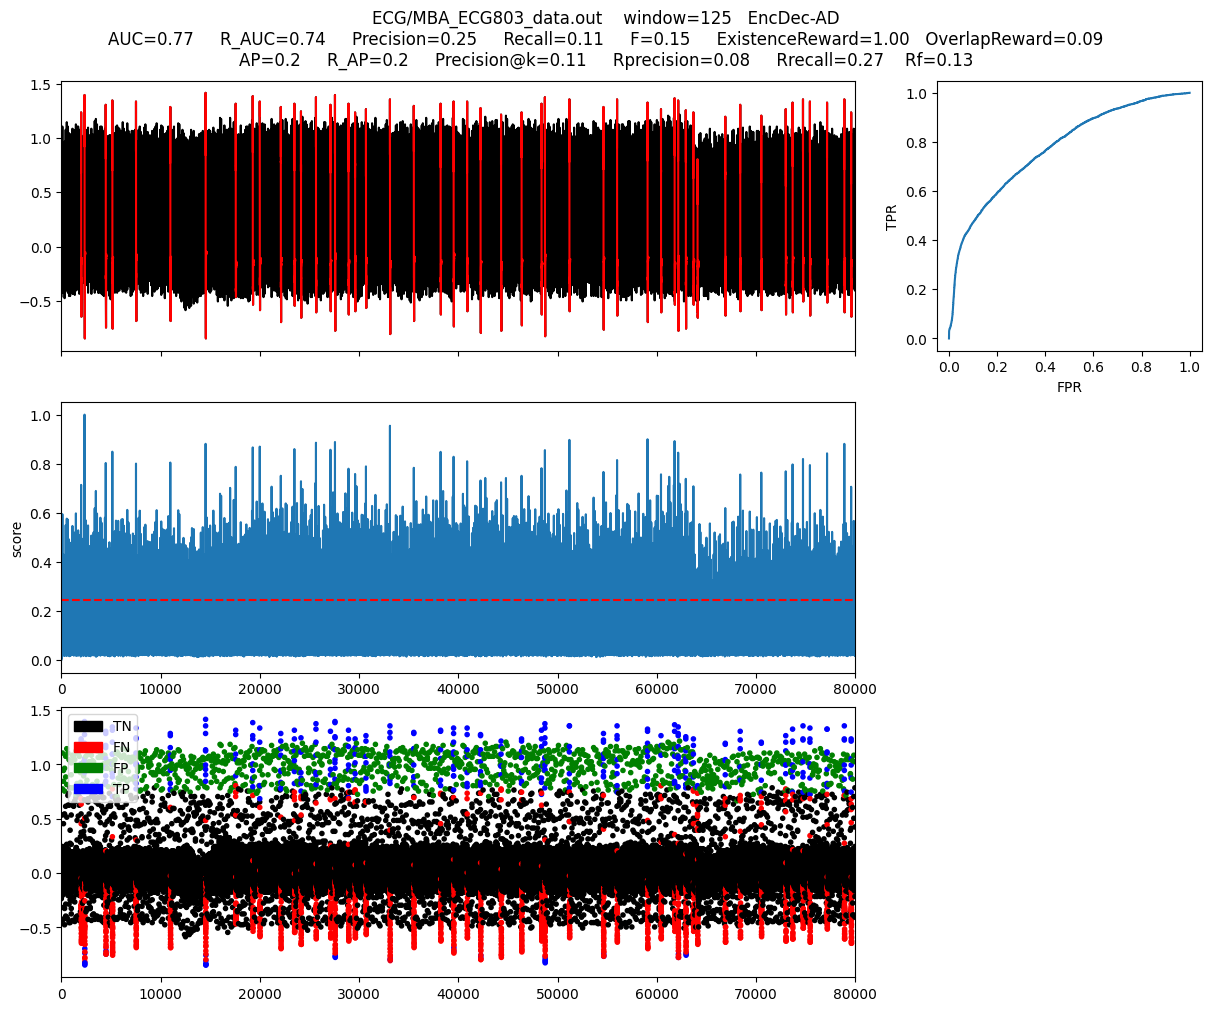

In [18]:
EncDecAD_model(df, filenames, normality, online_mode=False)

<h1>EncDec-AD-Batch </h1>
<h3>[Q6] Naive streaming variant (1):<br> Offline method is applied to each batch of the data that arrives. No modification of the method itself.</h3>
<p>Offline method: LSTM Encoder/Decoder - DeepADoTS implementation</p>


In [19]:

def EncDecAD_Batch_model(df: pd.DataFrame, filenames: List[str], normality:int, batch_size:int=10000):
    modelName = "EncDec-AD-Batch"
    start_time = time.time()
    
    # first batch boundaries
    i = 0
    start = 0
    end = min(batch_size, df.shape[0])
    
    # for gathering stream results
    score = np.empty(0)
    X_test = pd.DataFrame(columns=[0])
    Y_test = pd.Series(dtype=df[1].dtype)
    
    while start < df.shape[0] and end <= df.shape[0]:
        # log
        print(f"Batch {i}: [{start},{end}]")
        i+=1
        
        # apply non-streaming method on each batch independently
        batch = df.iloc[start:end].reset_index(drop=True)
        batch_score, batch_X_test, batch_Y_test = EncDecAD_model(batch, filenames, normality, online_mode=True)
        
        # append batch results
        score = np.concatenate((score, batch_score), axis=0)
        X_test = pd.concat([X_test, batch_X_test], ignore_index=True)  # needed for plotFig func
        Y_test = pd.concat([Y_test, batch_Y_test], ignore_index=True)  # points used for training are excluded from testing
        
        # move on to the next branch
        start += batch_size
        end += batch_size
        end = min(end, df.shape[0])
        
    
    # show evaluation results on the whole stream
    elapsed_time = time.time() - start_time
    sliding_window = find_length(df[0])
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    plotFig(X_test[0], Y_test, score, sliding_window, fileName="_".join(filenames), modelName=modelName)
    return gather_TSB_results(modelName, True, Y_test, score, sliding_window, filenames, normality, elapsed_time)



Batch 0: [0,10000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.32it/s]


Batch 1: [10000,20000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Batch 2: [20000,30000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:34<00:00,  1.15it/s]


Batch 3: [30000,40000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:35<00:00,  1.12it/s]


Batch 4: [40000,50000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.33it/s]


Batch 5: [50000,60000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.34it/s]


Batch 6: [60000,70000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


Batch 7: [70000,80000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


Batch 8: [80000,90000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:35<00:00,  1.13it/s]


Batch 9: [90000,100000]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:35<00:00,  1.12it/s]


{'model': 'EncDec-AD-Batch',
 'online': True,
 'normality': 1,
 'datasets': ['ECG/MBA_ECG803_data.out'],
 'series_length': 80000,
 'window': 125,
 'AUC': 0.6787190285748395,
 'Precision': 0.24603174603174602,
 'Recall': 0.10467532467532467,
 'F': 0.14686588921282798,
 'Precision@k': 0.10467532467532467,
 'Rprecision': 0.07651620370370371,
 'Rrecall': 0.2696230717639168,
 'Rf': 0.11920365785960084,
 'ExistenceReward': 0.9622641509433962,
 'OverlapReward': 0.09646280196904697,
 'RAUC': 0.7299727157937482,
 'time': 342.676340341568}

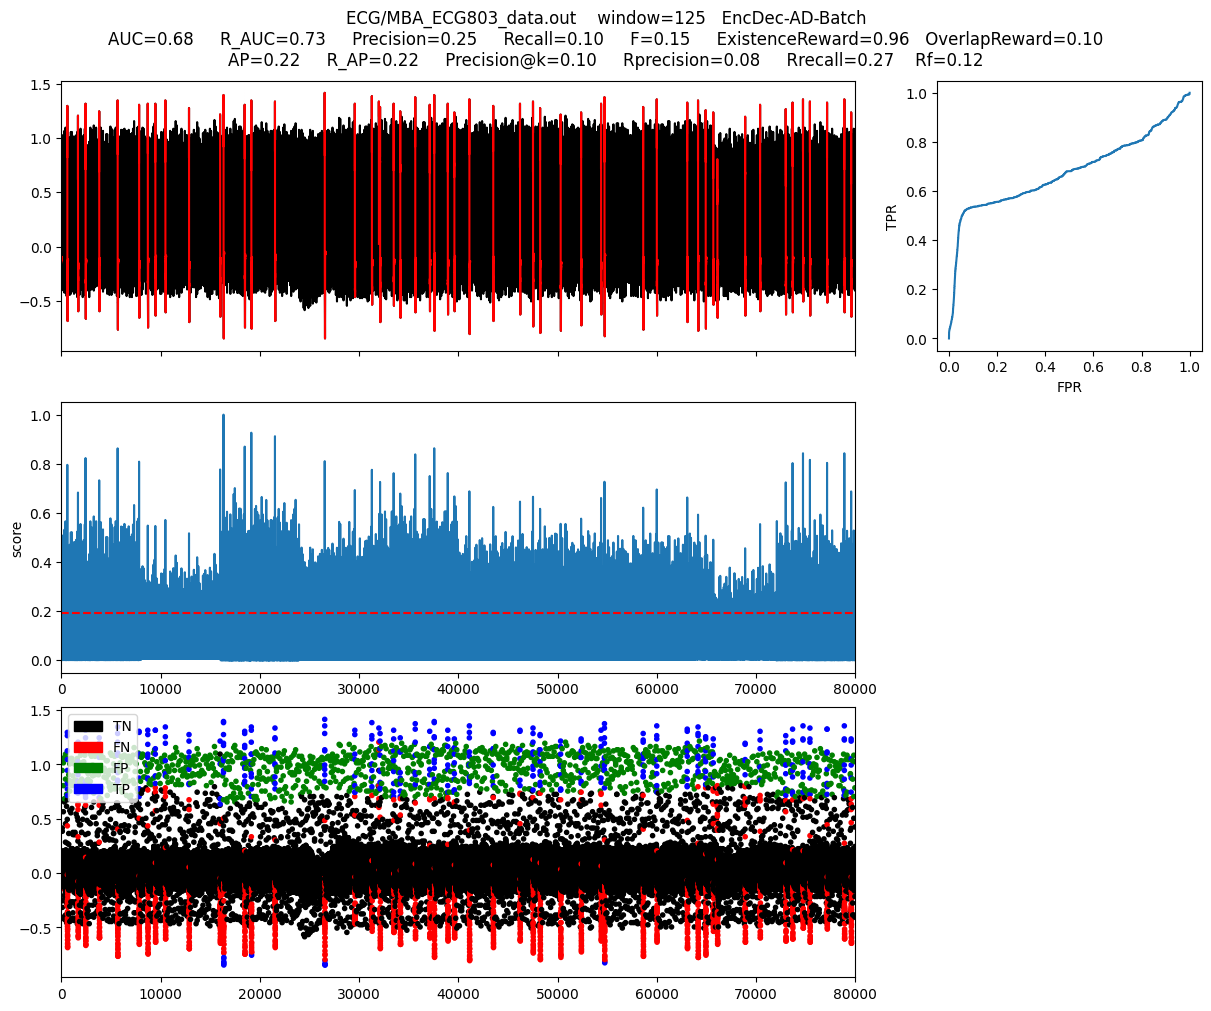

In [20]:
EncDecAD_Batch_model(df, filenames, normality, batch_size=10000)


<h1>EncDec-AD-Online </h1>
<h3>[Q6] Streaming variant 2: Streaming Anomaly Detection with Incremental Learning and Concept Drift Detection<br></h3>
<p>In the realm of time series anomaly detection, adapting to continuously arriving data points in a streaming setting is crucial for timely and accurate detection of anomalies. We propose an online adaptation of the EncDec-AD model, originally designed for offline detection using an LSTM autoencoder architecture. In our approach, the model is initially trained on a specified percentage of the initial data stream to establish a baseline. Subsequently, it undergoes incremental learning, updating its parameters in real-time as new data arrives. To address concept drift, which can significantly affect model performance, we integrate a Kolmogorov-Smirnov (KS) test to monitor reconstruction errors. This test detects significant changes in the error distribution, triggering a complete retraining of the model when necessary. This combination of initial training, incremental learning, and concept drift detection ensures that the EncDec-AD model remains accurate and responsive to changes in the data stream, making it well-suited for real-time anomaly detection in dynamic environments.
    
Summary:
<ul>
    <li>The EncDec-AD model (an LSTM Autoencoder) is initially trained using a percentage (train_perc) of the initial points in the data stream. </li> 
    <li>It is subsequently updated through incremental learning.</li> 
    <li>A concept drift detection mechanism monitors the model's predictions (reconstruction errors) and triggers the model to be retrained from scratch when significant changes are detected.</li> 
</ul>
</p>
    

In [ ]:
# TODO: move code from py here

<h1>AE-LSTM (Online/Streaming) </h1>
<h3>[Q6] Streaming variant 2: Online model sourced from GitHub to serve as an additional baseline</h3>
<p>LSTM Autoencoder methodology - redsofa (official) implementation</p>


In [21]:
sys.path.append(path.join(os.getcwd(), "redsofa_online_ae_lstm"))
from source.AELSTMOnline import AELSTMOnline
from source.baseAnomalyDetector import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from skmultiflow.data import FileStream


Number of GPUs Available:  1


In [22]:

# helper functions from original repo (OnlineAnomalyDetection.py):

def get_file_stream(data_source, target_column):
    if target_column == None:
        stream = FileStream(data_source, allow_nan=True, n_targets=0)
    else:
        stream = FileStream(data_source, allow_nan=True, n_targets=1, target_idx=target_column)
    return stream


def genericDetectorSteps(_detector, data_source, target_column, max_samples, batch_size):
    """
    This function include the general steps for an algorithm to detect anomaly for streaming data.
    predict_and_update() will be different based on the class type.
    :param _detector: The detected algorithm we are going to use
    :param data_source: The dataset link 
    :param batch_size: size of data to send to algorithm to each iteration for anomaly detection
    :param max_samples: maximum number of samples sent
    :param timestamp_column: column name in the data source which represents timestamp
    :param target_column: column name in the data source which represents target column
    :return: detector object
    """    
    _detector.stream = get_file_stream(data_source, target_column)
    _detector.start_time = time.time()

    if _detector.isPretrain:
        _detector.pre_train(_detector.isSupervised)
    else:
        # if not pretrain, skip these data
        _detector.get_next_stream(_detector.initial_batch_training_size)

    while _detector.n_samples < max_samples and _detector.stream.has_more_samples():
        # For LSTM, we need to get next sequence instead of data
        X, y = _detector.get_next_sequence(batch_size)
        _detector.predict_and_update(X,y)

    _detector.end_time = time.time()
    return _detector

# run AE-LSTM Online AD model: =======================================================================


def LSTMOnline_model(
    df: pd.DataFrame,
    filenames: List[str],
    initial_batch_training_size:int,
    neurons:int = 32,
    epochs:int = 30,
    target_column_idx:int = 1
):
    model_name = 'AE-LSTM'
    # save dataframe to a csv (temporarily)
    def prepare_dataset_dataframe() -> str:
        filenames_norm = re.sub(r'[^A-Za-z0-9_]',  '.',  "_".join(filenames))
        new_data_source = os.path.join("OUTPUTS", 'temp_dataframes', filenames_norm + "_converted.csv")
        os.makedirs(os.path.dirname(new_data_source), exist_ok=True)
        df.to_csv(new_data_source, index=False)
        return new_data_source
    
    max_samples = df.shape[0]
    new_data_source = prepare_dataset_dataframe()
    
    slidingWindow = find_length(df[0])
    batch_size = min(int(4 * (slidingWindow // 100) * 100), max_samples)
    
    # define model
    LSTM_model = LSTMOnline(name = model_name, 
        detector = AELSTMOnline(time_steps = slidingWindow, 
                                neurons = neurons, 
                                epochs = epochs, 
                                anomaly_rate = 30, 
                                n_batch = batch_size),
        data_source = new_data_source, 
        initial_batch_training_size = initial_batch_training_size,
        batch_size = batch_size, 
        max_samples = max_samples, 
        timestamp_column = None, 
        target_column = target_column_idx,
        isSupervised = False, 
        ifSaveResult = True, 
        isPretrain = True)
    
    # training
    start_time = time.time()
    LSTM_model = genericDetectorSteps(
        LSTM_model, new_data_source, target_column_idx, max_samples, batch_size)
    K.clear_session()
    
    # delete temporary file
    os.remove(new_data_source)
    
    # make predictions and show results
    results = LSTM_model.results()
    y_pred = np.array(LSTM_model.y_pred)
    label = df[1][initial_batch_training_size:].values
    elapsed_time = time.time() - start_time
    
    gather_AELSTM_results(model_name, df.shape[0], filenames, normality, results, label, y_pred, slidingWindow, elapsed_time)
    plotFig(df[0], label, y_pred, slidingWindow, fileName=new_data_source, modelName=model_name)
    
    return LSTM_model, y_pred, results


In [23]:
model, y_pred, results = LSTMOnline_model(df, filenames, initial_batch_training_size=1000)


AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift detected...
AE-LSTM start traning
AE-LSTM drift dete

TypeError: gather_AELSTM_results() missing 1 required positional argument: 'elapsed_time'